In [196]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import show, adjust_band
from matplotlib import cm
import matplotlib
from scipy import stats

from constants import *
os.chdir(home_dir)
import datetime
tmp = []
for i in range(len(fire_sn)):
    tmp.append(datetime.datetime.strptime(fire_sn['Ig_Date'][i], '%Y-%m-%d'))
fire_sn['dt'] = tmp

In [223]:
# san joaquin watershed
sj = sn_watersheds[sn_watersheds.name=='Upper San Joaquin']
# clip swe for every year
import datetime

swe_sj = {}
swe_sj_burned = {}
sai_sj = {}
sai_sj_burned = {}
gpp_sj = {}
gpp_tot_sj ={}
gpp_sj_burned = {}
gpp_tot_sj_burned ={}
ndvi_sj = {}
ndvi_sj_burned = {}
for yr in range(2000,2016):
    timestop =datetime.datetime(yr,10,1)
    timestart = datetime.datetime(yr-20,10,1)
    prev_fires = fire_sn[fire_sn['dt']<timestop]
    prev_fires = prev_fires[prev_fires['dt']>timestart]

    swe = rxr.open_rasterio(data_dir + 'max_swe'+str(yr)+'.tif')
    swe = swe.rio.write_crs(sj.crs)
    clipped = swe.rio.clip(sj.geometry,all_touched=True)
    swe_sj[yr]=clipped

    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    swe_sj_burned[yr]=in_fire

    #SAI
    sai = rxr.open_rasterio(pe_data_dir + 'sai_'+str(yr)+'.tif')
    clipped = sai.rio.clip(sj.geometry,all_touched=True)

    clipped[np.where(clipped==np.inf)]=np.nan
    clipped[np.where(clipped>3000)]=np.nan
    clipped[np.where(clipped<0)]=np.nan
    sai_sj[yr]=clipped
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    sai_sj_burned[yr]=in_fire
    # GPP
    id = yr-2000
    gpp_means = []
    gpp_means_burned = []
    gpp_all = {}
    gpp_all_burned = {}
    for mo in range(1,13):
        gppmean = 0
        gppmean_burned = 0
        try:
            tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(id)+'_'+str(mo)+'.tif')
            clipped = tmp.rio.clip(sj.geometry,all_touched=True)
            clipped[np.where(clipped>5000)] = np.nan
            gppmean = np.nanmean(clipped)
            gpp_all[mo]=clipped
            in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
            gpp_all_burned[mo]=in_fire
            gppmean_burned = np.nanmean(in_fire)
        except:
            continue
        gpp_means.append(gppmean)
        gpp_means_burned.append(gppmean_burned)
    max_mo = np.nanargmax(gpp_means)+1
    gpp = rxr.open_rasterio(data_dir+'modis_clip_'+str(id)+'_'+str(max_mo)+'.tif')
    clipped = gpp.rio.clip(sj.geometry,all_touched=True)
    clipped[np.where(clipped>5000)] = np.nan
    gpp_sj[yr]=clipped
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    gpp_sj_burned[yr]=in_fire
    gpp_sum = np.zeros((16,22))
    for k in gpp_all.keys():
        gpp_sum += gpp_all[k][0,:,:]
    gpp_tot_sj[yr]=gpp_sum
    gpp_sum_burned = np.zeros((in_fire.shape[1:]))
    for k in gpp_all_burned.keys():
        gpp_sum_burned += gpp_all_burned[k][0,:,:]
    gpp_tot_sj_burned[yr]=gpp_sum_burned


    #NDVI
    ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
    #pe = pe.rio.write_crs(sj.crs)
    clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    ndvi_sj[yr]=clipped
    ndvi_sj_burned[yr]=in_fire



In [238]:
gpp_by_month = np.zeros((16,12))
gpp_by_month_burned = np.zeros((16,12))
for yr in range(2000,2016):
    for mo in range(1,13):
            gppmean = 0
            gppmean_burned = 0
            try:
                tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(yr-2000)+'_'+str(mo)+'.tif')
                clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                clipped[np.where(clipped>5000)] = np.nan
                gppmean = np.nanmean(clipped)
                gpp_by_month[yr-2000, mo-1] = gppmean
                in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
                gpp_all_burned[mo]=in_fire
                gppmean_burned = np.nanmean(in_fire)
                gpp_by_month_burned[yr-2000, mo-1] = gppmean_burned
            except:
                continue


In [224]:
keys = range(2000,2015)
swe_means = [np.nanmean(swe_sj[k]) for k in keys]
sai_means = [np.nanmean(sai_sj[k]) for k in keys]
gpp_means = [np.nanmean(gpp_sj[k+1]) for k in keys]
ndvi_means = [np.nanmean(ndvi_sj[k+1]) for k in keys]
gpp_tot_means = [np.nanmean(gpp_tot_sj[k+1]) for k in keys]
swe_means_burned = [np.nanmean(swe_sj_burned[k]) for k in keys]
sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]
gpp_means_burned = [np.nanmean(gpp_sj_burned[k+1]) for k in keys]
ndvi_means_burned = [np.nanmean(ndvi_sj_burned[k+1]) for k in keys]
gpp_tot_means_burned = [np.nanmean(gpp_tot_sj_burned[k+1]) for k in keys]

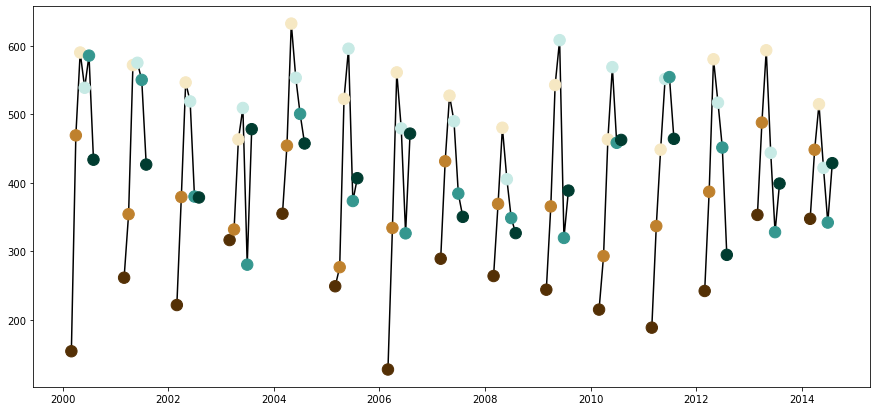

In [272]:
f,ax=plt.subplots(figsize=(15,7))
for yr in range(2000,2015):
    months = range(3,9)
    midx = [m-1 for m in months]
    data= gpp_by_month[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)
    

plt.show()


In [75]:
def normalize(data):
    avg = np.nanmean(data)
    out = (data-avg)/avg
    return out

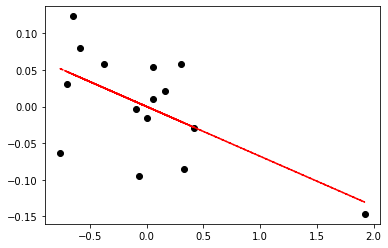

In [225]:
f,ax=plt.subplots()
x = normalize(sai_means)
y = normalize(gpp_means)
ax.plot(x,y,'ko')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

-0.1804438463139343 0.36971462179826226 0.016180053701167613


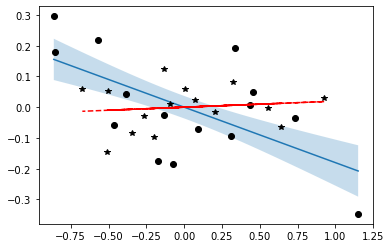

In [282]:
f,ax=plt.subplots()
x = normalize(swe_means_burned)
y = normalize(gpp_tot_means_burned)
#x = swe_means_burned
#y = gpp_means_burned
ax.plot(x,y,'ko')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25)
ax.plot(t, yi,'-')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, r_value**2,p_value)

x = swe_means
y = gpp_means
x = normalize(swe_means)
y = normalize(gpp_means)
ax.plot(x,y,'k*')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

32767

In [212]:

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, r_value**2,p_value)

-0.13449746158788095 0.23489536920379886 0.06710609826842588


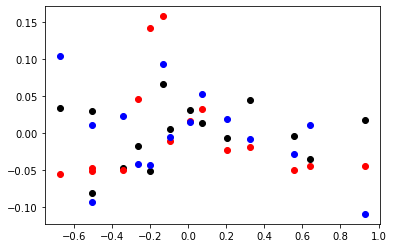

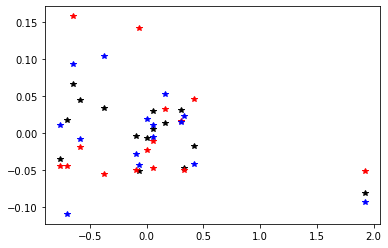

In [177]:
f,ax=plt.subplots()
plt.plot(normalize(swe_means),normalize(gpp_means),'ko')
plt.plot(normalize(swe_means),normalize(ndvi_means),'ro')
plt.plot(normalize(swe_means),normalize(gpp_tot_means),'bo')
plt.show()
f,ax=plt.subplots()
plt.plot(normalize(sai_means),normalize(gpp_means),'k*')
plt.plot(normalize(sai_means),normalize(ndvi_means),'r*')
plt.plot(normalize(sai_means),normalize(gpp_tot_means),'b*')
plt.show()

In [164]:
# san joaquin watershed
sj = sn_watersheds[sn_watersheds.name=='Upper San Joaquin']
# clip swe for every year
import datetime

swe_sj = {}
swe_sj_burned = {}
sai_sj = {}
sai_sj_burned = {}
gpp_sj = {}
gpp_tot_sj ={}
gpp_sj_burned = {}
gpp_tot_sj_burned ={}
ndvi_sj = {}
ndvi_sj_burned = {}
for yr in range(2000,2016):
    timestop =datetime.datetime(yr,10,1)
    timestart = datetime.datetime(yr-20,10,1)
    prev_fires = fire_sn[fire_sn['dt']<timestop]
    prev_fires = prev_fires[prev_fires['dt']>timestart]

    swe = rxr.open_rasterio(data_dir + 'max_swe'+str(yr)+'.tif')
    swe = swe.rio.write_crs(sj.crs)
    clipped = swe.rio.clip(sj.geometry,all_touched=True)
    swe_sj[yr]=clipped

    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    swe_sj_burned[yr]=in_fire

    #SAI
    sai = rxr.open_rasterio(pe_data_dir + 'sai_'+str(yr)+'.tif')
    clipped = sai.rio.clip(sj.geometry,all_touched=True)

    clipped[np.where(clipped==np.inf)]=np.nan
    clipped[np.where(clipped>3000)]=np.nan
    clipped[np.where(clipped<0)]=np.nan
    sai_sj[yr]=clipped
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    sai_sj_burned[yr]=in_fire
    # GPP
    id = yr-2000
    gpp_means = []
    gpp_means_burned = []
    gpp_all = {}
    gpp_all_burned = {}
    for mo in range(1,13):
        gppmean = 0
        gppmean_burned = 0
        try:
            tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(id)+'_'+str(mo)+'.tif')
            clipped = tmp.rio.clip(sj.geometry,all_touched=True)
            clipped[np.where(clipped>5000)] = np.nan
            gppmean = np.nanmean(clipped)
            gpp_all[mo]=clipped
            in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
            gpp_all_burned[mo]=in_fire
            gppmean_burned = np.nanmean(in_fire)
        except:
            continue
        gpp_means.append(gppmean)
        gpp_means_burned.append(gppmean_burned)
    max_mo = np.nanargmax(gpp_means)+1
    gpp = rxr.open_rasterio(data_dir+'modis_clip_'+str(id)+'_'+str(max_mo)+'.tif')
    clipped = gpp.rio.clip(sj.geometry,all_touched=True)
    gpp_sj[yr]=clipped
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    gpp_sj_burned[yr]=in_fire
    gpp_sum = np.zeros((16,22))
    for k in gpp_all.keys():
        gpp_sum += gpp_all[k][0,:,:]
    gpp_tot_sj[yr]=gpp_sum
    gpp_sum_burned = np.zeros((in_fire.shape[1:]))
    for k in gpp_all_burned.keys():
        gpp_sum_burned += gpp_all_burned[k][0,:,:]
    gpp_tot_sj_burned[yr]=gpp_sum_burned


    #NDVI
    ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
    #pe = pe.rio.write_crs(sj.crs)
    clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
    ndvi_sj[yr]=clipped
    ndvi_sj_burned[yr]=in_fire



In [171]:
keys = sai_sj.keys()
swe_means_burned = [np.nanmean(swe_sj_burned[k]) for k in keys]
sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]
gpp_means_burned = [np.nanmean(gpp_sj_burned[k]) for k in keys]
ndvi_means_burned = [np.nanmean(ndvi_sj_burned[k]) for k in keys]
gpp_tot_means_burned = [np.nanmean(gpp_tot_sj_burned[k]) for k in keys]

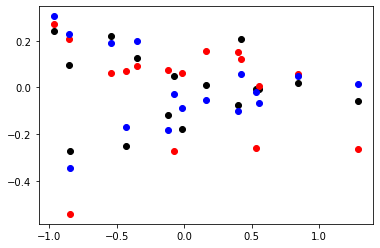

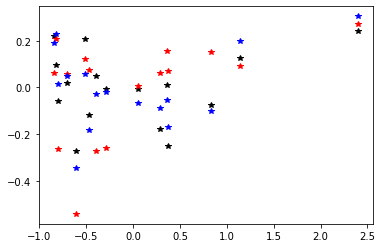

In [172]:
f,ax=plt.subplots()
plt.plot(normalize(swe_means_burned),normalize(gpp_means_burned),'ko')
plt.plot(normalize(swe_means_burned),normalize(ndvi_means_burned),'ro')
plt.plot(normalize(swe_means_burned),normalize(gpp_tot_means_burned),'bo')
plt.show()
f,ax=plt.subplots()
plt.plot(normalize(sai_means_burned),normalize(gpp_means_burned),'k*')
plt.plot(normalize(sai_means_burned),normalize(ndvi_means_burned),'r*')
plt.plot(normalize(sai_means_burned),normalize(gpp_tot_means_burned),'b*')
plt.show()

    

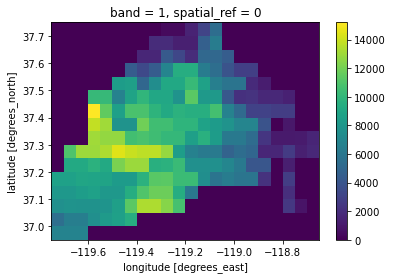

In [128]:
tmp.plot()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()